## Avaliação Módulo - Aprendizado Dinâmico

<span style='color:green'><strong>Produzido por Arion Melkan de Freitas</strong></span>

<span style='color:black'>Para esta avaliação, você deve entregar três arquivos: <ul><li>
    Um arquivo de dados em .csv com a base resultante das análises</li><li>
    Um relatório em .ipynb com suas análises comentadas</li><li>
    Um arquivo .pdf gerado a partir do .ipynb</li></ul>

Os dados de casos confirmados e mortes diárias por COVID-19 nos Estados Unidos estão
disponíveis no arquivo covid19USA.csv. </span>

In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import random as rd

from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller, acf, pacf, pacf_ols
from statsmodels.tsa.api import ExponentialSmoothing

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Ignorar warnings não prejudiciais
import warnings
warnings.filterwarnings("ignore")

rd.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

%matplotlib inline

sns.set()

In [2]:
# Recuperando os dados
pkgdir    = r'C:\Users\Arion\Documents\Machine Learning\MBA - Ciências de Dados\Aprendizado Dinâmico\Avaliacao_modulo'
covid_csv = 'covid19USA.csv'

In [3]:
# Definindo os tamanhos das imagens desse notebook
rcParams['figure.figsize'] = 8, 6

### Questão 1
Você deve fazer a leitura dos dados, estabelecer um índice por datas, verificar se os
dados estão corretos e realizar algum procedimento necessário caso haja dados
faltantes.

#### Leitura do csv e a formação do dataframe

In [4]:
# Fazendo a leitura dos dados
df_covidUSA = pd.read_csv(f'{pkgdir}\\{covid_csv}', index_col = 'date', parse_dates = True)

# Visualizando os 5 primeiros registros
df_covidUSA.head(5)

confirmed  deaths
date                         
2020-01-01          0       0
2020-01-02          0       0
2020-01-03          0       0
2020-01-04          0       0
2020-01-05          0       0

In [5]:
df_covidUSA.describe()

confirmed       deaths
count    247.000000   247.000000
mean   24754.680162   752.000000
std    21935.393529   768.724934
min        0.000000     0.000000
25%       19.500000     1.000000
50%    23705.000000   661.000000
75%    41252.500000  1180.500000
max    78427.000000  4928.000000

<span style='color:black'>
    Análise descritiva básica, para saber a média, desvio padrão, os interquantis e os valores mínimos e máximos dos atributos confirmed e deaths.
</span>

#### Análise para escolher o índice por datas

In [6]:
df_covidUSA.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-08-25', '2020-08-26', '2020-08-27', '2020-08-28',
               '2020-08-29', '2020-08-30', '2020-08-31', '2020-09-01',
               '2020-09-02', '2020-09-03'],
              dtype='datetime64[ns]', name='date', length=247, freq=None)

<span style='color:black'>Olhando o meu índice de data, percebo que eu tenho uma análise do covid dos USA no ano 2020 (Embora o esperado não fosse diferente disso) e, a princípio, as datas seguem de forma sequencial e referenciando todos os dias de cada semana de um determinado mês.
    <br>
    <br>Eu farei mais um pouco de análise e ver se não falta nenhuma data para aplicar o index.freq 'D' neste conjunto de dados.
</span>

#### Análise de Dados Faltantes

In [7]:
attr_a = 'confirmed'
attr_b = 'deaths'

In [8]:
def show_isna(df, attr = ''):
    
    if attr == '':
        print(f'Existem valores nulos:\n{df.isna().sum()}\n')
    else:  
        print(f'Existem valores nulos para o atributo {attr}:\n{df[attr].isna().sum()}\n')

In [9]:
# Exibindo os possíveis valores nulos
show_isna(df_covidUSA, attr_a)

show_isna(df_covidUSA, attr_b)

Existem valores nulos para o atributo confirmed:
0

Existem valores nulos para o atributo deaths:
0



In [10]:
def show_duplicated(df):
    
    if df.index.duplicated().sum() == 0:
        duplicado = 'não'
    else:
        duplicado = 'sim'
    
    print(f'Existe alguma data duplicada no dataframe: {duplicado} - {df.index.duplicated().sum()}')

In [11]:
# Exibir algum índice duplicado
show_duplicated(df_covidUSA)

Existe alguma data duplicada no dataframe: não - 0


In [12]:
# Avaliando a quantidade de dados no dataframe e identificando se existe a possibilidade de faltar algum dia até o dia 
# 3 de Setembro
print(f'A quantidade de registros que temos no dataframe é de: {df_covidUSA.shape[0]} registros')

A quantidade de registros que temos no dataframe é de: 247 registros


<span style='color:black'>Aqui eu fiz uma conta simples para validar as 247 possíveis datas: <ul><li>Contei os meses com os 31 dias, 5 * 31 = 155 dias</li><li>Depois somei com 29 dias de fevereiro, 2020 é bissexto</li><li>Por fim, multipliquei por 2 com os meses de 30 dias, somei mais 3 dias de setembro e somei com os passos anteriores. <br>155 + 29 + 63 = 247 dias.</li><br>Resultado foi semelhante ao obtido recuperando a quantidade de linhas que eu tenho no dataframe.</ul></span>

In [13]:
df_covidUSA.index.freq = 'D'

df_covidUSA.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-08-25', '2020-08-26', '2020-08-27', '2020-08-28',
               '2020-08-29', '2020-08-30', '2020-08-31', '2020-09-01',
               '2020-09-02', '2020-09-03'],
              dtype='datetime64[ns]', name='date', length=247, freq='D')

<span style='color:black'>Agora sim.
    <br>Consegui validar que são 247 dias e as datas seguem de forma sequencial sem repetição.
    <br>Inseri a frequência diária.
</span>

#### Análise dos dados - graficamente

In [14]:
title = 'COVID-19 nos Estados Unidos'

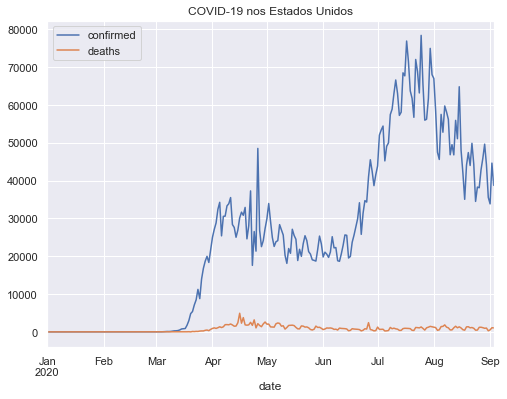

In [15]:
df_covidUSA.plot(title = title);

In [16]:
covidUSA_c = df_covidUSA.query('confirmed > 0')[[attr_a, attr_b]].copy()

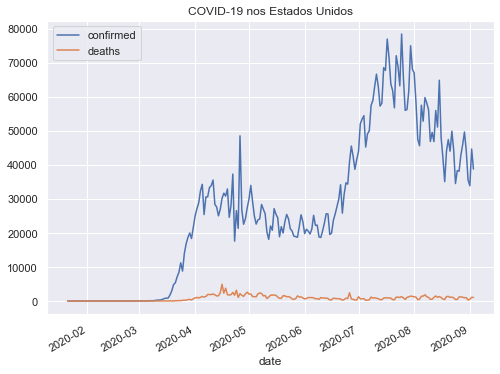

In [17]:
covidUSA_c.plot(title = title);

In [18]:
covidUSA_c.head(10)

confirmed  deaths
date                         
2020-01-21          1       0
2020-01-25          1       0
2020-01-27          3       0
2020-01-31          1       0
2020-02-01          1       0
2020-02-02          1       0
2020-02-03          3       0
2020-02-06          1       0
2020-02-11          1       0
2020-02-13          1       0

<span style='color:black'>Embora não solicite isso explicitamente na prova, inseri os gráficos para se ter uma ideia do comportamento do atributo confirmado e um pouco do número de mortos, este atributo veremos mais adiante na questão 2.
    <br>Visualizei também os dados do dataframe onde eu fiz o filtro do atributo confirmado, apenas para se ter uma ideia uma vez que os dados no começo da base estão zerados.
    <br>
    <br>Importante: Durante o filtro que eu realizei, deu para perceber que em alguns dias faltaram dados de forma que as datas deixam de ser sequencial. Por exemplo dia 27-01-20 teve número de confirmados, mas dia 28-01 não e assim em diante, não sendo uma frequência diária.
    <br>
    <br>Observação: O número de confirmados visualmente segue uma tendência não estacionária (Reduzindo a uma certa janela é possível deixar de ser não estacionária) e com grande variação na sazonalidade.
    <br>Lembrando que essa foi uma primeira visualização inicial dos dados.
</span>

### Questão 2

Proponha uma decomposição dos dados de mortes em tendência e sazonalidade.
Obtenha os gráficos de autocorrelação e autocorrelação parcial. Comente
brevemente os resultados.

#### Decompor os dados de mortes em tendência e sazonalidade

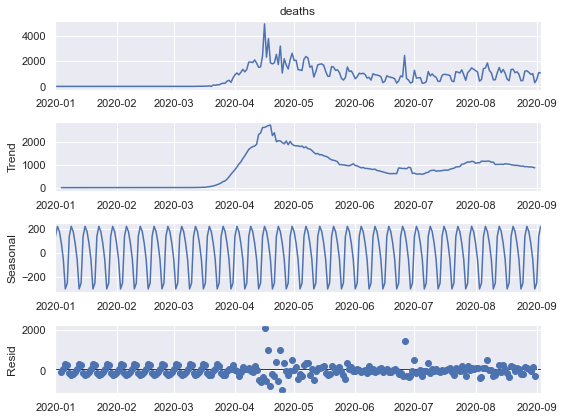

In [19]:
result_death_add = seasonal_decompose(df_covidUSA[attr_b], model='additive')

result_death_add.plot();

<span style='color:black'> Eu comecei usando toda a base de dados, percebi para o atributo mortes que a primeira apiração de morte ocorre em Março. Eu farei um filtro recuperando o valor da morte maior que 0 para refazer o seasonal_decompose em modelo aditivo e multiplicativo.
<br>
<br>Não usei o modelo multiplicativo com a base toda, pois o modelo não se adapta com os valores zerados.<br>Visto em aula a média para o modelo multiplicativo é em torno de 1 enquanto no aditivo é 0.</span>

##### Tratamento no conjunto de dados - Começando a partir da primeira morte

In [20]:
covidUSA = df_covidUSA.query('deaths > 0')[[attr_a, attr_b]].copy()

print(f'Quantidade de registros e colunas após o filtro do número de mortes ser maior do que 0: {covidUSA.shape}')

Quantidade de registros e colunas após o filtro do número de mortes ser maior do que 0: (186, 2)


In [21]:
covidUSA.head(25)

confirmed  deaths
date                         
2020-03-01          3       1
2020-03-02         20       1
2020-03-03         14       4
2020-03-04         22       3
2020-03-05         34       2
2020-03-06         74       1
2020-03-07        105       2
2020-03-08         95       3
2020-03-09        121       4
2020-03-10        200       5
2020-03-11        271       2
2020-03-12        287       2
2020-03-13        351      10
2020-03-14        511       7
2020-03-15        777      10
2020-03-16        823      12
2020-03-17        887      16
2020-03-18       1766      23
2020-03-19       2988      42
2020-03-21       5374     110
2020-03-22       7123      80
2020-03-23       8459     131
2020-03-24      11236     119
2020-03-25       8789     211
2020-03-26      13963     249

<span style='color:black'>Aparentemente, recuperando as primeiras 25 datas, percebi, durante o filtro, que eu retirei a data do dia 20-03-20, pois estava zerada no atributo deaths. Além desse tipo de visualização, corrobora também o fato que retornou 186 registros ao invés de um esperado que seria 187 registros, pois a intenção era retirar os dois primeiros meses onde temos o número de deaths igual a zero.
    <br>Incluirei essa data, utilizando o date_range do pandas.
</span>

In [22]:
covidUSA.index

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2020-08-25', '2020-08-26', '2020-08-27', '2020-08-28',
               '2020-08-29', '2020-08-30', '2020-08-31', '2020-09-01',
               '2020-09-02', '2020-09-03'],
              dtype='datetime64[ns]', name='date', length=186, freq=None)

In [23]:
idx = pd.date_range(start = covidUSA.index.min(), end = covidUSA.index.max(), freq='D')
idx

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2020-08-25', '2020-08-26', '2020-08-27', '2020-08-28',
               '2020-08-29', '2020-08-30', '2020-08-31', '2020-09-01',
               '2020-09-02', '2020-09-03'],
              dtype='datetime64[ns]', length=187, freq='D')

In [24]:
covidUSA = covidUSA.reindex(idx)

covidUSA.head(25)

confirmed  deaths
2020-03-01        3.0     1.0
2020-03-02       20.0     1.0
2020-03-03       14.0     4.0
2020-03-04       22.0     3.0
2020-03-05       34.0     2.0
2020-03-06       74.0     1.0
2020-03-07      105.0     2.0
2020-03-08       95.0     3.0
2020-03-09      121.0     4.0
2020-03-10      200.0     5.0
2020-03-11      271.0     2.0
2020-03-12      287.0     2.0
2020-03-13      351.0    10.0
2020-03-14      511.0     7.0
2020-03-15      777.0    10.0
2020-03-16      823.0    12.0
2020-03-17      887.0    16.0
2020-03-18     1766.0    23.0
2020-03-19     2988.0    42.0
2020-03-20        NaN     NaN
2020-03-21     5374.0   110.0
2020-03-22     7123.0    80.0
2020-03-23     8459.0   131.0
2020-03-24    11236.0   119.0
2020-03-25     8789.0   211.0

In [25]:
show_isna(covidUSA)

Existem valores nulos:
confirmed    1
deaths       1
dtype: int64



In [26]:
covidUSA_c[32:37]

confirmed  deaths
date                         
2020-03-16        823      12
2020-03-17        887      16
2020-03-18       1766      23
2020-03-19       2988      42
2020-03-20       4835       0

In [27]:
values = {'confirmed' : covidUSA_c.iloc[36][attr_a], 'deaths' : 1}

covidUSA.fillna(value = values, inplace = True, limit=1)
covidUSA.iloc[20][attr_b] = covidUSA.iloc[20][attr_b] -1

covidUSA.iloc[19:21]

confirmed  deaths
2020-03-20     4835.0     1.0
2020-03-21     5374.0   109.0

In [28]:
covidUSA[18:25]

confirmed  deaths
2020-03-19     2988.0    42.0
2020-03-20     4835.0     1.0
2020-03-21     5374.0   109.0
2020-03-22     7123.0    80.0
2020-03-23     8459.0   131.0
2020-03-24    11236.0   119.0
2020-03-25     8789.0   211.0

<span style='color:black'>Realizei a inclusão do valor 1 de deaths e o valor verdadeiro do confirmed, puxando do outro dataframe, retirando - 1 do número de mortes do dia 21-03 para preservar a quantidade total de números de mortos.
    <br> Eu poderia fazer de n formas e mesmo que seja uma possível falha de input nesse dia, prefiri trabalhar desse jeito com os dados nesse momento.
</span>

#### Decompor os dados de mortes em tendência e sazonalidade com o filtro do atributo deaths

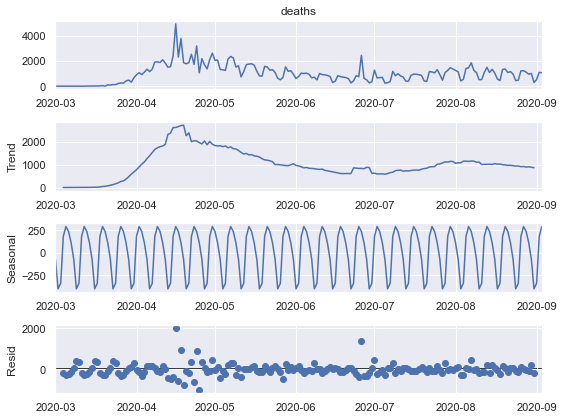

In [29]:
result_death_add = seasonal_decompose(covidUSA[attr_b], model='additive')

result_death_add.plot();

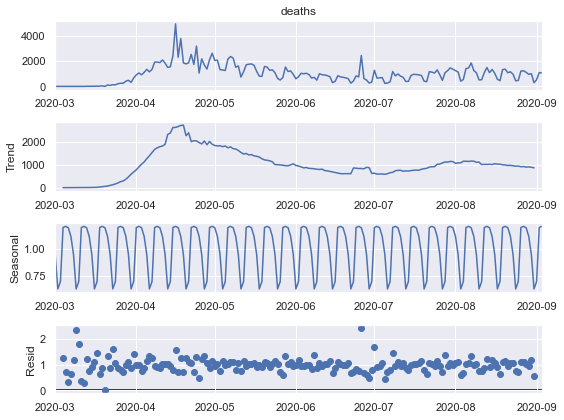

In [30]:
result_death_mul = seasonal_decompose(covidUSA[attr_b], model='multiplicative')

result_death_mul.plot();

<span style='color:black'>Olhando os gráficos da decomposição sazonal, respectivamente com os modelos aditivos e multiplicativos, a tendência e a sazonalidade permanceram as mesmas. Enquanto nos resíduos houve a diferença na centralização dos pontos entre valores 0 e 1, 0 ao aditivo e 1 ao multiplicativo. Além disso, teve a diferença na escala onde o aditivo temos em torno de -2.000 a 2.000 e o multiplicativo em torno de 0 a 2.
<br>Mesmo que os dois possuem pontos distantes, possíveis outliers, dos demais e no multiplicativo o começo está mais aberto, olhando os gráficos me leva a crer que no multiplicativo os dados tiveram um melhor comportamento.
<br>
<br>Aprofundarei um pouco mais para entender se a decomposição sazonal com o modelo multiplicativo é o que se adequa melhor aos dados do covid dos EUA.</span>

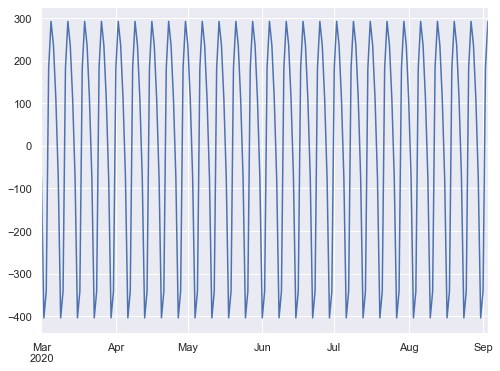

In [31]:
result_death_add.seasonal.plot();

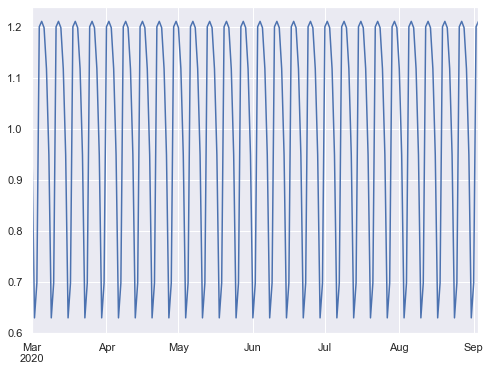

In [32]:
result_death_mul.seasonal.plot();

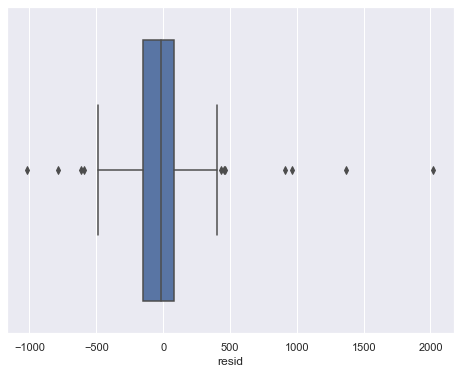

In [33]:
sns.boxplot(result_death_add.resid);

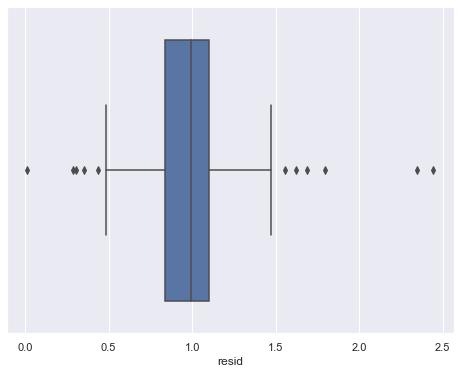

In [34]:
sns.boxplot(result_death_mul.resid);

<span style='color:black'>Os resultados das decomposições sazonais, sazonal e resíduos, dos modelos aditivo e multiplicativo foram parecidos.
<br>Quando vi o sazonal, o resultado dos dois modelos foram semelhantes com uma pequena diferença no pico de cima, onde no aditivo ele é mais afunilado do que no multiplicativo.<br>O resíduo inseri num boxplot, conforme até citado na primeira tutoria, para avaliar as possíveis diferenças. Vale resaltar que aparentemente os dados se comportaram do mesmo jeito no resultado dos modelos, a diferença ainda é a escala. Ainda sim não diz muito sobre qual é o que se adapta melhor a esse conjunto de dados.</span>

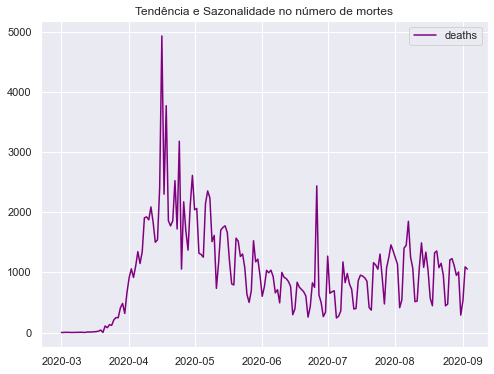

In [35]:
title  = 'Tendência e Sazonalidade no número de mortes'

plt.plot(covidUSA[attr_b], 'purple');
plt.legend([attr_b])
plt.title(title);

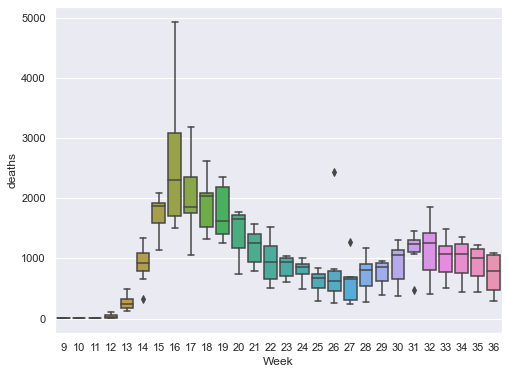

In [36]:
week = 'Week'

covidUSA[week] = covidUSA.index.week

sns.boxplot(x=covidUSA[week], y=covidUSA[attr_b]);

<span style='color:black'>Coloquei o gráfico com a tendência e sazonalidade para avaliar os dados de mortes do covid19 EUA.<br>Tanto a tendência quanto a sazonalidade possuem momentos diferentes ao longo dessa série.
<br>Percebo na tendência que temos um crescimento exponecial no número de mortos no fim de Março até meados de Abril, depois um decréscimo, um crescimento elevado entre Junho e Julho e, no final, indicando que o número de mortos se manteve no intervalo de 1000 por dia, com algumas exceções.
<br>
<br>Inseri um boxplot definido por semana também para avaliar de acordo com a 9ª até a 36ª semana e identificar alguma anomalia. Os boxplots da semana 14, 26, 27 e 31 tiveram outliers.
<br>É bem possível que num determinado dia ocorreu a entrada de mais números de mortos, porque não foi reportado ao final de semana ou mesmo algum erro humano ou sistêmico em um dia e depois a correção no dia ou nos dias posteriores, ou a possibilidade de terem ajustado os dados uma vez que temos outilers (14ª e 31ª semana) com um ponto abaixo do bigode do boxplot.</span>

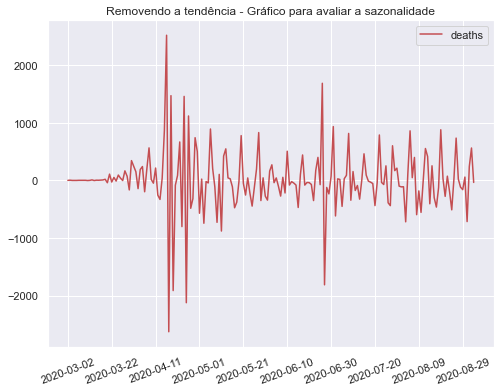

In [37]:
title = 'Removendo a tendência - Gráfico para avaliar a sazonalidade'

# Gráfico da diferença das mortes - Uma tentativa de eliminar a tendência
y = np.diff(covidUSA[attr_b])
x = covidUSA.index[1:]

plt.plot(x,y, 'r')
plt.legend([attr_b])
plt.title(title)
plt.xticks(np.arange(x.min(),x.max(), 20, dtype='datetime64[D]'),rotation=20);

<span style='color:black'>Neste gráfico retirei a tendência para ver unicamente o comportamento da sazonalidade, no qual indica que em diferentes períodos de tempos a sazonalidade teve comportamentos diferentes. Devido a sazonalidade se comportar de diferentes jeitos ao longo do tempo, os três próximos gráficos olharei, junto com o aspecto de tendência e não só a sazonalidade, o período de dois em dois meses para identificar se em algum momento ocorreu uma sazonalidade aditiva.</span>

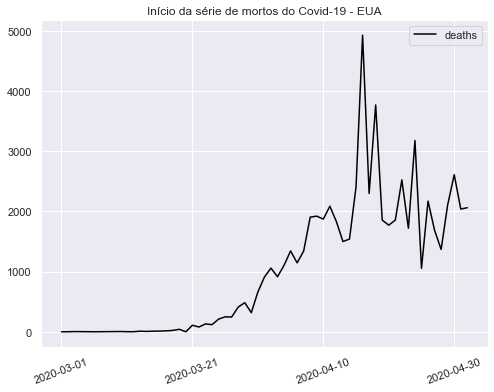

In [38]:
dat_min = '2020-03-01'
dat_max = '2020-05-02'
title_s = 'Início da série de mortos do Covid-19 - EUA'

plt.plot(covidUSA[attr_b][dat_min : dat_max], 'black');
plt.legend([attr_b])
plt.title(title_s)
plt.xticks(np.arange(dat_min, dat_max, 20, dtype='datetime64[D]'), rotation=20);

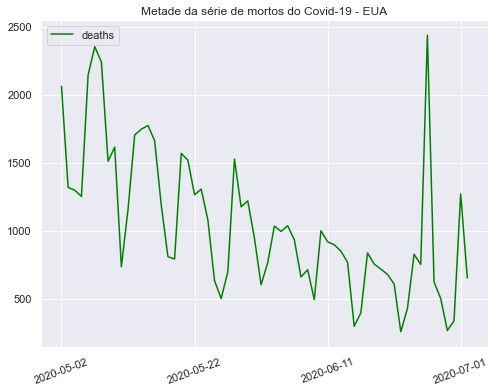

In [39]:
dat_min = '2020-05-02'
dat_max = '2020-07-02'
title_s = 'Metade da série de mortos do Covid-19 - EUA'

plt.plot(covidUSA[attr_b][dat_min : dat_max], 'green');
plt.legend([attr_b])
plt.title(title_s)
plt.xticks(np.arange(dat_min, dat_max, 20, dtype='datetime64[D]'), rotation=20);

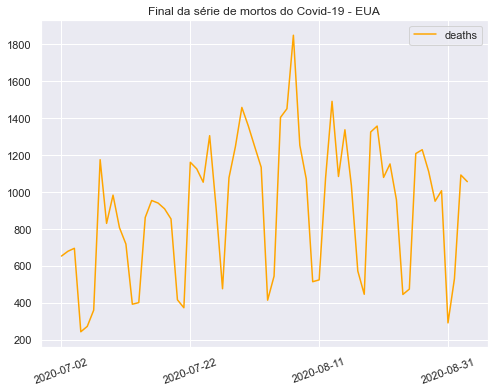

In [40]:
dat_min = '2020-07-02'
dat_max = '2020-09-03'
title_s = 'Final da série de mortos do Covid-19 - EUA'

plt.plot(covidUSA[attr_b][dat_min : dat_max], 'orange');
plt.legend([attr_b])
plt.title(title_s)
plt.xticks(np.arange(dat_min, dat_max, 20, dtype='datetime64[D]'), rotation=20);

<span style='color:black'>Pela série dividida em três momentos, ficou mais evidente de que a sazonalidade teve diferentes formas de crescimento ou decrescimento durante o período do covid-19 coletado, não mantendo uma regularidade ou pelo menos uma estimativa de crescimento ou decrescimento nesses períodos, indicando alguma tendência aditiva. Seguindo essa linha de raciocínio, o modelo multiplicativo se adequa melhor para esse conjunto de dados.</span>

##### Avaliando a série para identificar possível estacionariedade

In [41]:
# Lista de Atributos para etapa Estacionária
lst_attrib_est = ['deaths', 'MMEP-7', 'DPEP-7']

In [42]:
covidUSA[lst_attrib_est[1]] = covidUSA[lst_attrib_est[0]].ewm(span=7, adjust=False).mean()
covidUSA[lst_attrib_est[2]] = covidUSA[lst_attrib_est[0]].ewm(span=7, adjust=False).std()

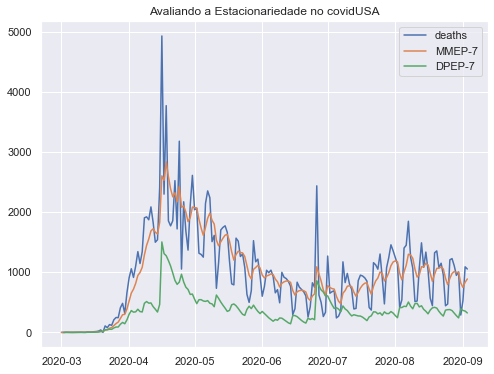

In [43]:
title  = 'Avaliando a Estacionariedade no covidUSA'

plt.plot(covidUSA[lst_attrib_est]);
plt.legend(lst_attrib_est)
plt.title(title);

<span style='color:black'>
    Utilizei a média ponderada, porque além de utilizar um peso, aplicando maiores pesos para os valores mais recentes, para determinar as médias. Ajuda também a algumas desvantagens da MMS. Por exemplo:
    <ul>
        <li>Dentro do conjunto covidUSA, temos situação onde a MMS não representará direito alguns picos de mortes</li>
    </ul>
    <br>
    Utilizei o adjust = False para calcular da seguinte maneira:<br>
    $\begin{array}{ll}\overline{Z}_0 &= Z_1 \\
        \overline{Z}_t &= (1 - \alpha) Z_{t-1} + \alpha Z_t,
    \end{array}$ 
    <br>
    o que é equivalente a usar os pesos 
    $w_i = \begin{cases}
            \alpha (1 - \alpha)^i & \text{se } i < t \\
            (1 - \alpha)^i        & \text{se } i = t.
    \end{cases}$
    <br>
    Informação retirada do material.
</span>

##### Teste de Hipótese para saber a estacionariedade do dataframe com o filtro de mortes

<span style='color:black'>Para esse teste de hipótese tenho as seguintes premissas:
<ul>
    <li>$H_0: \mbox{ a série é não estacionária e contém uma raiz unitária}$</li>
    <li>$H_1: \mbox{ a série é estacionária ou tendência-estacionária}$</li>
    <li>$p \geq 0.05$</li>
</ul>
</span>

In [44]:
def dickey_fuller(df, attr, diff_1 = False, diff_2 = False):
    
    if diff_1 == False and diff_2 == False:          
        result = adfuller(df[attr], autolag='AIC')
        
    elif diff_1 == True and diff_2 == False:        
        result = adfuller(np.diff(df[attr]), autolag='AIC')
        
    elif diff_1 == False and diff_2 == True:        
        result = adfuller(np.diff(np.diff(df[attr])), autolag='AIC')
        
    else:
        print('Ainda não existe essa opção com diff_1 e 2 igual a True')

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    return result[1]

In [45]:
def show_result_df(p_valor, alfa = 5):
    
    if p_valor >= alfa and p_valor < 20:
        print(f'\nVisto que o meu p_valor no teste do dickey fuller foi {p_valor:.2f}% e é maior que 5% do'
              ' meu teste de significância.'
              '\nNão rejeito a hipótese nula, H0, ou seja há evidências fracas de que a série não é estacionária.')
    
    elif p_valor > 20:
        print(f'\nVisto que o meu p_valor no teste do dickey fuller foi {p_valor:.2f}% e é maior que 5% do'
              ' meu teste de significância.'
              '\nNão rejeito a hipótese nula, H0, ou seja há evidências fortes de que a série não é estacionária.')
        
    elif p_valor < alfa:
        print(f'\nVisto que o meu p_valor no teste do dickey fuller foi {p_valor:.2f}% e é menor que 5% do'
              ' meu teste de significância.'
              '\nRejeito a hipótese nula, H0, ou seja há evidências de que a série é estacionária ou tendência-estacionária.')


In [46]:
p_valor = dickey_fuller(covidUSA, attr_b)

p_valor *= 100

show_result_df(p_valor)

ADF Statistic: -2.731639
p-value: 0.068721
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576

Visto que o meu p_valor no teste do dickey fuller foi 6.87% e é maior que 5% do meu teste de significância.
Não rejeito a hipótese nula, H0, ou seja há evidências fracas de que a série não é estacionária.


##### Avaliando a primeira diferença 

In [47]:
p_valor = dickey_fuller(covidUSA, attr_b, diff_1 = True)

p_valor *= 100

show_result_df(p_valor)

ADF Statistic: -4.092712
p-value: 0.000996
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576

Visto que o meu p_valor no teste do dickey fuller foi 0.10% e é menor que 5% do meu teste de significância.
Rejeito a hipótese nula, H0, ou seja há evidências de que a série é estacionária ou tendência-estacionária.


##### Avaliando a segunda diferença

In [48]:
p_valor = dickey_fuller(covidUSA, attr_b, diff_2 = True)

p_valor *= 100

show_result_df(p_valor)

ADF Statistic: -7.180162
p-value: 0.000000
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576

Visto que o meu p_valor no teste do dickey fuller foi 0.00% e é menor que 5% do meu teste de significância.
Rejeito a hipótese nula, H0, ou seja há evidências de que a série é estacionária ou tendência-estacionária.


<span style='color:black'>Eu fiz essa parte para dar mais confiabilidade em dizer que há evidências fracas de que a série não possui estacionariedade, realizando a análise desde os gráficos até chegar ao teste de dickey fuller. Visto que a série possui uma evidência fraca de não estacionariedade, aproveitei para olhar a primeira e segunda diferença.
    <br>Analisando a primeira e a segunda diferença da série, rejeito a hipótese nula e a série, nas diferenças, é estacionária ou tendência-estacionária.
</span>

#### Análise das funções: fac e facp

In [49]:
acf(covidUSA[attr_b])

array([ 1.00000000e+00,  7.24043734e-01,  6.68567897e-01,  5.38821976e-01,
        5.24919648e-01,  5.69047459e-01,  6.87915941e-01,  6.73053261e-01,
        6.59964876e-01,  4.51937125e-01,  4.01905231e-01,  3.60640025e-01,
        3.84862448e-01,  4.50685451e-01,  5.00821738e-01,  3.77151652e-01,
        2.73127495e-01,  1.35547040e-01,  1.28846190e-01,  1.33687332e-01,
        2.03966177e-01,  2.28015004e-01,  1.46984172e-01, -9.59687738e-04,
       -6.84662694e-02, -1.31068141e-01, -9.16866160e-02, -3.85317489e-02,
       -9.46270866e-03, -6.87996646e-02, -1.97941821e-01, -2.78125471e-01,
       -2.82336035e-01, -2.86092357e-01, -2.03449518e-01, -1.85676920e-01,
       -2.34567170e-01, -3.13589326e-01, -3.89123176e-01, -4.03178399e-01,
       -3.62086153e-01])

In [50]:
pacf(covidUSA[attr_b])

array([ 1.        ,  0.72793644,  0.31036278, -0.04136956,  0.14335012,
        0.29727902,  0.42575365,  0.09424445,  0.03841389, -0.40621226,
       -0.14292107,  0.00990852, -0.10587335, -0.01002193,  0.11661334,
       -0.13420651, -0.21958218, -0.16810242, -0.01728885, -0.06891708,
        0.01685913,  0.09057574, -0.10087002, -0.12914537, -0.00582305,
       -0.06131386, -0.0650135 ,  0.03325015,  0.04240696,  0.01464736,
       -0.1062174 , -0.01776098,  0.06351745, -0.06791525, -0.02748372,
       -0.04746656, -0.00932041,  0.06772541, -0.0153469 , -0.05106379,
       -0.02413935])

In [51]:
pacf_ols(covidUSA[attr_b])

array([ 1.        ,  0.72407458,  0.3111484 , -0.03615931,  0.1458415 ,
        0.30249355,  0.43127359,  0.11063528,  0.05670311, -0.37669475,
       -0.13313614,  0.00929599, -0.10256094, -0.00892644,  0.11851623,
       -0.11612099, -0.20114161, -0.1426068 , -0.00521615, -0.0675697 ,
        0.01755322,  0.09775815, -0.08767598, -0.1170913 ,  0.01780811,
       -0.03829685, -0.07491792,  0.03068301,  0.04610231, -0.01694689,
       -0.11314374, -0.01572906,  0.02507174, -0.09848966, -0.02985152,
       -0.04860137, -0.06697661,  0.00723112, -0.02923429, -0.08330276,
       -0.07332465])

<span style='color:black'>Fiz isso para facilitar as visualizações das correlações com os atrasos da série.
    <br>Olhando a autocorrelação parcial com yule-walker e o mínimo quadrados ordinários (ols), o primeiro atraso tem uma certa correlação e se comporta melhor com o YW, porém no segundo e no terceiro atraso o ols tem um melhor resultado mesmo que no terceiro atraso já não temos uma correlação. Depois do terceiro atraso em diante, com o método YW se comportou melhor.
    <br>Na autocorrelação, os atrasos possuem pouca correlação com a série.
</span>

#### Avaliar a representação gráfica da autocorrelação de mortes

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


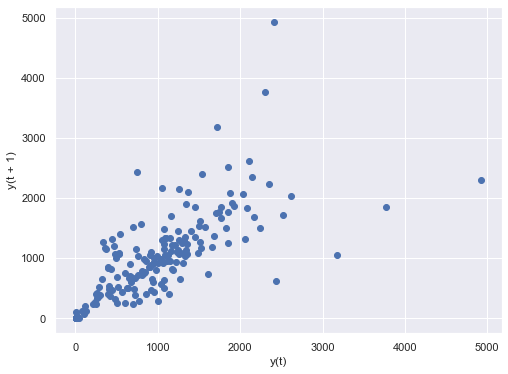

In [52]:
lag_plot(covidUSA[attr_b]);

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


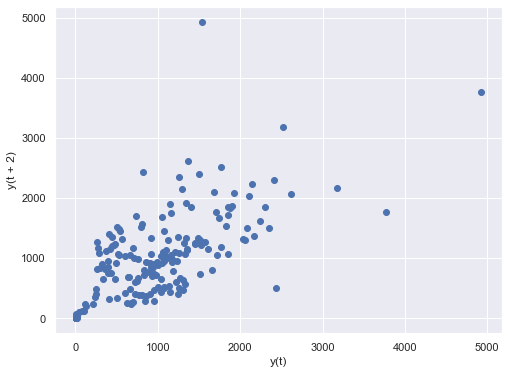

In [53]:
lag_plot(covidUSA[attr_b], lag=2);

<span style='color:black'>A correlação com o atraso 1, analisando o gráfico, possui no começo dos dados uma possível correlação alta, mas quanto mais andamos para a direita do gráfico mais acontece a dispersão dos dados. Com o atraso 2 a correlação diminui em comparação com o de atraso 1.
<br>Isso ocorre, pois tivemos momentos onde o crescimento e o decrescimento variou desde exponencial até nas últimas 4 ou 3 semanas onde tivemos uma certa linearidade, além dos outliers encontrados.</span>

#### Análise dos gráficos de Autocorrelação e Autocorrelação Parcial

In [54]:
title = 'Autocorrelação: De dados de mortos pelo Covid-19 nos USA'
lags = 40

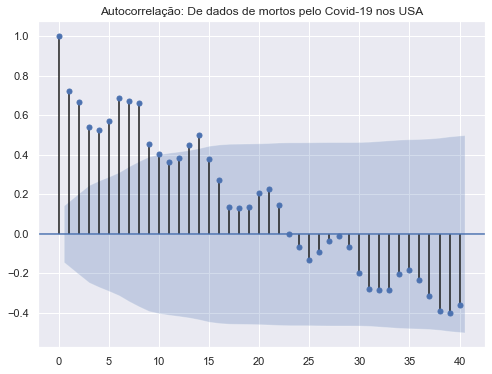

In [55]:
plot_acf(covidUSA[attr_b],title=title,lags=lags);

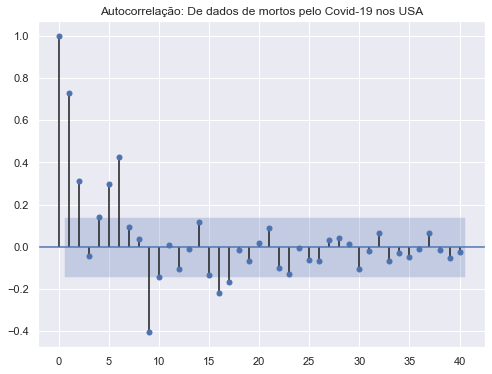

In [56]:
plot_pacf(covidUSA[attr_b],title=title,lags=lags);

<span style='color:black'>Explorei o cenário de autocorrelação e a autocorrelação parcial com as seguintes premissas: 
    <ul>
        <li>Filtro do ínicio de mortes nos EUA - covidUSA_deaths.</li>
        <li>Lag de 40.</li>
    </ul>
    <br>Na autocorrelação parcial, embora algumas correlações por exemplo no lag 9 seja negativo de -0.4 eu não rejeito a significância dessa correlação por estar fora da região azul (área de rejeição do teste de siginificância da correlação), olhando o gráfico eu considero um modelo MA(2).
    <br>Já na autocorrelação, percebo que possui uma forma de senoide, além de existirem bastante pontos que preciso levar em consideração e que tem importância na correlação. Olhando apenas o gráfico, eu considero um modelo ARMA(1,1) ou ARMA(2,1).
</span>

### Questão 3
<span>Divida a base em treino e teste, com 21 observações na base de teste. Você deverá
apresentar em distintas colunas na mesma base de dados que será entregue: 
    <ul><li>Os dados originais de casos confirmados e mortes.</li>
        <li>As previsões de Holt e Holt Winters para a variável mortes.</li>
        <li>As previsões obtidas pelo melhor modelo SARIMA, com ordens selecionadas
segundo critério preestabelecido para a variável mortes. Identifique as
componentes desse melhor modelo (por exemplo, “o modelo tem uma
componente autorregressiva não sazonal de ordem.., uma componente de
médias móveis não-sazonal de ordem.., etc).</li>
        <li>As previsões obtidas por um modelo de redes dinâmicas para a variável
mortes.</li>
    </ul>
</span>



#### Dividindo a base de dados em treino e testes

<span style='color:black'>Utilizarei o conjunto de dados do covidUSA, nos fóruns e durante a prova, como aplicaremos para a variável morte, eu retirarei os dois primeiros meses onde temos um período de 0 mortes, então aproveitarei a análise já feita em cima desse do conjunto covidUSA.</span>

In [57]:
# Dividindo a base
dados_treino, dados_teste = train_test_split(covidUSA, test_size=0.112, random_state=0, shuffle = False)

# Exibir a quantidade de dados de treino e quantidade de dados dos testes
print(f'Tamanho do treino: {len(dados_treino)}\nTamanho do teste: {len(dados_teste)}')

Tamanho do treino: 166
Tamanho do teste: 21


In [58]:
# Olhando os dados de treino
show_isna(dados_treino)

# Olhando os dados de teste
show_isna(dados_teste)

Existem valores nulos:
confirmed    0
deaths       0
Week         0
MMEP-7       0
DPEP-7       1
dtype: int64

Existem valores nulos:
confirmed    0
deaths       0
Week         0
MMEP-7       0
DPEP-7       0
dtype: int64



In [59]:
# Exibir algum índice duplicado nos dados de treino
show_duplicated(dados_treino)

# Exibir algum índice duplicado nos dados de teste
show_duplicated(dados_teste)

Existe alguma data duplicada no dataframe: não - 0
Existe alguma data duplicada no dataframe: não - 0


In [60]:
covidUSA.head(10)

confirmed  deaths  Week    MMEP-7    DPEP-7
2020-03-01        3.0     1.0     9  1.000000       NaN
2020-03-02       20.0     1.0    10  1.000000  0.000000
2020-03-03       14.0     4.0    10  1.750000  1.697056
2020-03-04       22.0     3.0    10  2.062500  1.487299
2020-03-05       34.0     2.0    10  2.046875  1.231438
2020-03-06       74.0     1.0    10  1.785156  1.156973
2020-03-07      105.0     2.0    10  1.838867  0.994396
2020-03-08       95.0     3.0    10  2.129150  1.015593
2020-03-09      121.0     4.0    11  2.596863  1.241320
2020-03-10      200.0     5.0    11  3.197647  1.555962

<span style='color:black'>
    Este valor nulo na coluna do DPEP-7 foi porque utilizei uma janela de 7 dias, usando a função de peso exponencial, e no primeiro ponto, para o desvio padrão, não foi computado um valor.
</span>

#### Utilizando o método Holt e Holt-Winters, realizando a previsão

In [61]:
# Inicialização das variáveis
num_treino = len(dados_treino)
num_teste  = len(dados_teste)

# Treino
covid_h_ajusted_a   = ExponentialSmoothing(dados_treino[attr_b], trend='add').fit()
covid_h_ajusted_m   = ExponentialSmoothing(dados_treino[attr_b], trend='mul').fit()
covid_hw_ajusted_a  = ExponentialSmoothing(dados_treino[attr_b], trend='add', seasonal='add').fit()
covid_hw_ajusted_am = ExponentialSmoothing(dados_treino[attr_b], trend='add', seasonal='mul').fit()
covid_hw_ajusted_m  = ExponentialSmoothing(dados_treino[attr_b], trend='mul', seasonal='mul').fit()

# Previsão
covid_h_pred_a   = covid_h_ajusted_a.forecast(num_teste).rename('Previsão Holt Aditiva')
covid_h_pred_m   = covid_h_ajusted_m.forecast(num_teste).rename('Previsão Holt Multiplicativa')
covid_hw_pred_a  = covid_hw_ajusted_a.forecast(num_teste).rename('Previsão Holt-Winters Aditiva')
covid_hw_pred_am = covid_hw_ajusted_am.forecast(num_teste).rename('Previsão Holt-Winters Aditiva e Multiplicativa')
covid_hw_pred_m  = covid_hw_ajusted_m.forecast(num_teste).rename('Previsão Holt-Winters Multiplicativa')

# Ajuste do index
covid_h_pred_a.index    = covidUSA.index[num_treino:]
covid_h_pred_m.index    = covidUSA.index[num_treino:]
covid_hw_pred_a.index   = covidUSA.index[num_treino:]
covid_hw_pred_am.index  = covidUSA.index[num_treino:]
covid_hw_pred_m.index   = covidUSA.index[num_treino:]

In [62]:
covid_h_pred_a.head()

2020-08-14    1126.029816
2020-08-15    1132.818038
2020-08-16    1139.606260
2020-08-17    1146.394481
2020-08-18    1153.182703
Freq: D, Name: Previsão Holt Aditiva, dtype: float64

In [63]:
covid_h_pred_m.head()

2020-08-14    1086.450545
2020-08-15    1079.967988
2020-08-16    1073.524111
2020-08-17    1067.118683
2020-08-18    1060.751474
Freq: D, Name: Previsão Holt Multiplicativa, dtype: float64

In [64]:
covid_hw_pred_a.head()

2020-08-14    1327.389972
2020-08-15    1164.748873
2020-08-16     979.619957
2020-08-17     697.419088
2020-08-18     773.349739
Freq: D, Name: Previsão Holt-Winters Aditiva, dtype: float64

In [65]:
covid_hw_pred_am.head()

2020-08-14    1513.935012
2020-08-15    1228.421831
2020-08-16     984.891332
2020-08-17     475.743212
2020-08-18     625.060960
Freq: D, Name: Previsão Holt-Winters Aditiva e Multiplicativa, dtype: float64

In [66]:
covid_hw_pred_m.head()

2020-08-14    1455.924924
2020-08-15    1146.305757
2020-08-16     912.112839
2020-08-17     424.434057
2020-08-18     545.668931
Freq: D, Name: Previsão Holt-Winters Multiplicativa, dtype: float64

In [67]:
def show_plot_pred(covid, attr, label):
    dados_treino[attr].plot(legend=True, label='Treino')
    dados_teste[attr].plot(legend=True, label='Teste')
    
    covid_h_pred_a.plot(legend=True, label=covid_h_pred_a.name);
    covid_h_pred_m.plot(legend=True, label=covid_h_pred_m.name);
    covid.plot(legend=True, label=label);

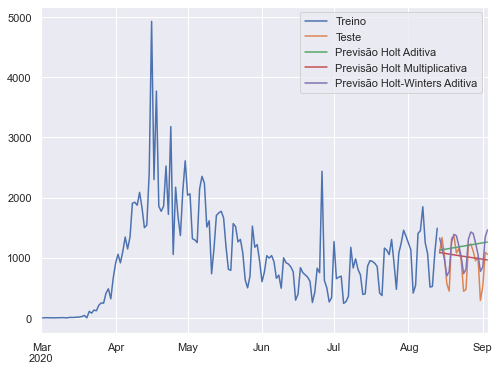

In [68]:
show_plot_pred(covid_hw_pred_a, attr_b, covid_hw_pred_a.name)

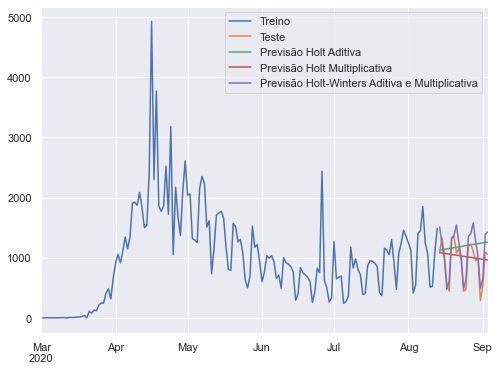

In [69]:
show_plot_pred(covid_hw_pred_am, attr_b, covid_hw_pred_am.name)

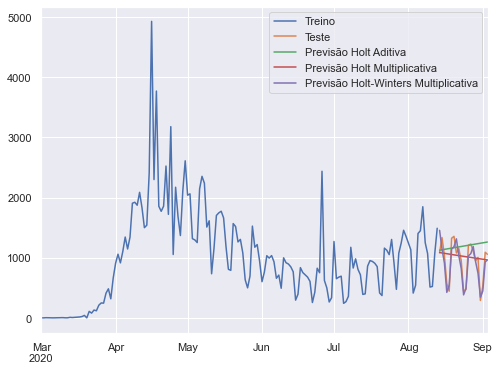

In [70]:
show_plot_pred(covid_hw_pred_m, attr_b, covid_hw_pred_m.name)

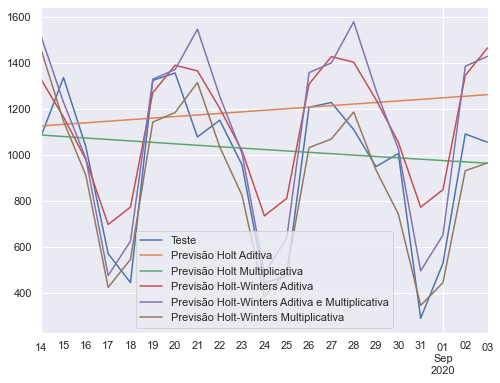

In [71]:
dados_teste[attr_b].plot(legend=True, label='Teste')

covid_h_pred_a.plot(legend=True, label=covid_h_pred_a.name);
covid_h_pred_m.plot(legend=True, label=covid_h_pred_m.name);
covid_hw_pred_a.plot(legend=True, label=covid_hw_pred_a.name);
covid_hw_pred_am.plot(legend=True, label=covid_hw_pred_am.name);
covid_hw_pred_m.plot(legend=True, label=covid_hw_pred_m.name);

<span style='color:black'>
    Nenhuma das previsões conseguiu acompanhar algumas nuances do conjunto de teste, porém as duas melhores foram, na respectiva ordem:
    <ol>
        <li>Holt-Winters com tendência e sazonalidade multiplicativa</li>
        <li>Holt-Winters com tendência aditiva e sazonalidade multiplicativa</li>
    </ol>
    <br>Em comparação com as duas previsões, a HW com tendência e sazonalidade multiplicativa foi a que chegou mais próximo de prever os dados de testes, obteve um resultado mais satisfatório, pois não se distanciou muito dos valores do teste. O que já muda na previsão HW com tendência aditiva e sazonalidade multiplicativa, em alguns cenários de picos e baixas. Também a sensação que ocorreu foi a previsão HW com tendência aditiva e sazonalidade multiplicativa não acompanhar a tendência de conjunto de teste, onde ocorria um decréscimo do número de mortes.
    <br>
    <br>Já os piores modelos foram: 
    <ol>
        <li>Holt com tendência aditiva.</li>
        <li>Holt com tendência Multiplicativa.</li>
        <li>Holt-Winters com tendência e sazonalidade aditiva.</li>
    </ol>
    <br>Os dois primeiros seguem uma previsão linear crescente e decrescente, respectivamente, e embora mostrem a tendência não temos a real percepção de alta e baixa nos dias. Depois o modelo A previsão HW com tendência e sazonalidade aditiva já se adequa melhor em relação ao Holt add e Holt mul, porém seus valores estão distantes das outras previsão HW e, principalmente, do conjunto de teste.
</span>

#### Obtendo a melhor previsão do modelo SARIMA

##### SARIMA sem variável exógena

In [72]:
auto_arima(dados_treino[attr_b], seasonal=True, m=7).summary()


stepwise_fit = auto_arima(dados_treino[attr_b], start_p=0, start_q=0,
                          max_p=6, max_q=4, m=7,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=2578.535, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=2681.405, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=2555.023, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=2603.352, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=2843.673, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=2554.110, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=2555.563, Time=0.04 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=2554.698, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=2535.879, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=2517.104, Time=0.40 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=2495.797, Time=1.09 sec
 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=2495.539, Time=0.81 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=2494.115, Time=0.43 sec
 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=2528.462, Time=0.15 sec
 ARIMA(2,0,0)(1,0,2)[7] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  166
Model:             SARIMAX(1, 0, 3)x(1, 0, [1], 7)   Log Likelihood               -1235.509
Date:                             Tue, 22 Sep 2020   AIC                           2485.018
Time:                                     10:54:13   BIC                           2506.802
Sample:                                          0   HQIC                          2493.861
                                             - 166                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9703      0.021     47.077      0.000       0.930       1.011
ma.L1         -0.6689      0.059    -11.243      0.000      -0.786      -0.552
ma.L2          0.3258      0.075      4.347      0.000       0.179       0.473
ma.L3         -0.2725      0.072     -3.781      0.000      -0.414      -0.131
ar.S.L7        0.9889      0.030     32.693      0.000       0.930       1.048
ma.S.L7       -0.9015      0.110     -8.218      0.000      -1.117      -0.686
sigma2      1.582e+05      1e+04     15.786      0.000    1.39e+05    1.78e+05
===================================================================================
Ljung-Box (Q):                       54.77   Jarque-Bera (JB):              2887.01
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             2.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<span style='color:black'>
    O melhor modelo gerado foi o <strong>SARIMA(1,0,3)(1,0,1)7</strong>.
    <br>Este modelo é composto dos seguintes modelos:
    <br>
    <br>Analisando o primeiro trecho do modelo, (p,d,q) - componentes não-sazonais
    <ul>
        <li><strong>1 componente autoregressiva não-sazonal de ordem 1</strong>.</li>
        <li>0 - Sem componente integrado não-sazonal.</li>
        <li><strong>3 componentes de médias móveis não-sazonais de ordem 3</strong>.</li>
    </ul>
    <br>
    <br>Analisando o segundo trecho do modelo, (P,D,Q) - componentes sazonais mais o m
    <ul>
        <li><strong>1 componente autoregressiva sazonal de ordem 1</strong>.</li>
        <li>0 - Sem componente integrado sazonal.</li>
        <li><strong>1 componente de médias móveis sazonal de ordem 1</strong>.</li>
    </ul>
    <br>O m representa o período da sazonalidade, definido por 7.
</span>

In [73]:
# Treinando com o melhor modelo
modelo = SARIMAX(dados_treino[attr_b],order=(1,0,3),seasonal_order=(1,0,1,7))

resultado = modelo.fit()
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              deaths   No. Observations:                  166
Model:             SARIMAX(1, 0, 3)x(1, 0, [1], 7)   Log Likelihood               -1235.509
Date:                             Tue, 22 Sep 2020   AIC                           2485.018
Time:                                     10:54:27   BIC                           2506.802
Sample:                                 03-01-2020   HQIC                          2493.861
                                      - 08-13-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9703      0.021     47.077      0.000       0.930       1.011
ma.L1         -0.6689      0.059    -11.243      0.000      -0.786      -0.552
ma.L2          0.3258      0.075      4.347      0.000       0.179       0.473
ma.L3         -0.2725      0.072     -3.781      0.000      -0.414      -0.131
ar.S.L7        0.9889      0.030     32.693      0.000       0.930       1.048
ma.S.L7       -0.9015      0.110     -8.218      0.000      -1.117      -0.686
sigma2      1.582e+05      1e+04     15.786      0.000    1.39e+05    1.78e+05
===================================================================================
Ljung-Box (Q):                       54.77   Jarque-Bera (JB):              2887.01
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             2.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
# Obtendo valores preditos do Sarima(1,0,3)(1,0,1,7)
inicio=len(dados_treino)
fim=len(dados_treino) + len(dados_teste) - 1

previsoes = resultado.predict(start=inicio, end=fim, dynamic=False, typ='levels').rename('Previsões SARIMA(1,0,3)(1,0,1,7) ')
previsoes.index = dados_teste.index

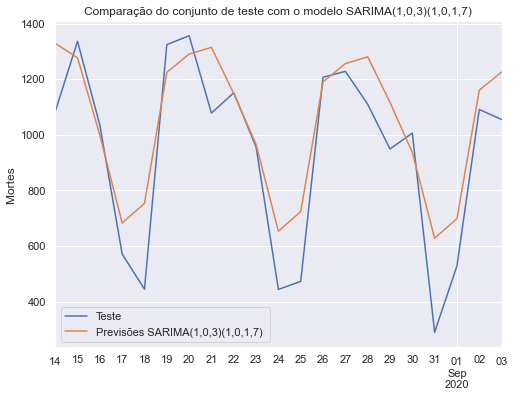

In [75]:
ylabel='Mortes '
xlabel=''
title_sarima = 'Comparação do conjunto de teste com o modelo SARIMA(1,0,3)(1,0,1,7)'

ax = dados_teste[attr_b].plot(legend=True, title=title_sarima, label='Teste')
previsoes.plot(legend=True)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

<span style='color:black'>
    Olhando o gráfico, a previsão SARIMA teve um bom resultado, porém não acompanhou as quedas dos números de mortes em alguns dias, por exemplo: 18/08, 24/08 e 31/08.
</span>

##### SARIMA com variável exógena

In [76]:
auto_arima(dados_treino[attr_b], exog=dados_treino[attr_a], seasonal=True, m=7).summary()


stepwise_fit_ex = auto_arima(dados_treino[attr_b], start_p=0, start_q=0,
                          max_p=6, max_q=4, m=7,
                          exog=covidUSA[attr_a],
                          seasonal=True,
                          trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)           

stepwise_fit_ex.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=2578.535, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=2681.405, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=2555.023, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=2603.352, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=2843.673, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=2554.110, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=2555.563, Time=0.04 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=2554.698, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=2535.879, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=2517.104, Time=0.42 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=2495.797, Time=1.46 sec
 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=2495.539, Time=1.10 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=2494.115, Time=0.69 sec
 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=2528.462, Time=0.22 sec
 ARIMA(2,0,0)(1,0,2)[7] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  166
Model:             SARIMAX(1, 0, 3)x(1, 0, [1], 7)   Log Likelihood               -1235.509
Date:                             Tue, 22 Sep 2020   AIC                           2485.018
Time:                                     10:55:47   BIC                           2506.802
Sample:                                          0   HQIC                          2493.861
                                             - 166                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9703      0.021     47.077      0.000       0.930       1.011
ma.L1         -0.6689      0.059    -11.243      0.000      -0.786      -0.552
ma.L2          0.3258      0.075      4.347      0.000       0.179       0.473
ma.L3         -0.2725      0.072     -3.781      0.000      -0.414      -0.131
ar.S.L7        0.9889      0.030     32.693      0.000       0.930       1.048
ma.S.L7       -0.9015      0.110     -8.218      0.000      -1.117      -0.686
sigma2      1.582e+05      1e+04     15.786      0.000    1.39e+05    1.78e+05
===================================================================================
Ljung-Box (Q):                       54.77   Jarque-Bera (JB):              2887.01
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             2.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<span style='color:black'>
    O melhor modelo gerado com a variável exógena foi o <strong>SARIMA(1,0,3)(1,0,1)7</strong>.
    <br>Este modelo é composto dos seguintes modelos:
    <br>
    <br>Analisando o primeiro trecho do modelo, (p,d,q) - componentes não-sazonais
    <ul>
        <li><strong>1 componente autoregressiva não-sazonal de ordem 1</strong>.</li>
        <li>0 - Sem componente integrado não-sazonal.</li>
        <li><strong>3 componentes de médias móveis não-sazonais de ordem 3</strong>.</li>
    </ul>
    <br>
    <br>Analisando o segundo trecho do modelo, (P,D,Q) - componentes sazonais mais o m
    <ul>
        <li><strong>1 componente autoregressiva sazonal de ordem 1</strong>.</li>
        <li>0 - Sem componente integrado sazonal.</li>
        <li><strong>1 componente de médias móveis sazonal de ordem 1</strong>.</li>
    </ul>
    <br>O m representa o período da sazonalidade, definido por 7.
</span>

In [77]:
# Treinando com o melhor modelo
modelo_ex = SARIMAX(dados_treino[attr_b], exog=dados_treino[attr_a], order=(1,0,3),seasonal_order=(1,0,1,7))

resultado_ex = modelo_ex.fit()
resultado_ex.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              deaths   No. Observations:                  166
Model:             SARIMAX(1, 0, 3)x(1, 0, [1], 7)   Log Likelihood               -1231.568
Date:                             Tue, 22 Sep 2020   AIC                           2479.136
Time:                                     10:56:07   BIC                           2504.032
Sample:                                 03-01-2020   HQIC                          2489.241
                                      - 08-13-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
confirmed      0.0233      0.009      2.610      0.009       0.006       0.041
ar.L1          0.9588      0.031     30.685      0.000       0.898       1.020
ma.L1         -0.6838      0.079     -8.709      0.000      -0.838      -0.530
ma.L2          0.2612      0.089      2.932      0.003       0.087       0.436
ma.L3         -0.2190      0.084     -2.620      0.009      -0.383      -0.055
ar.S.L7        0.9211      0.115      8.006      0.000       0.696       1.147
ma.S.L7       -0.7561      0.164     -4.600      0.000      -1.078      -0.434
sigma2      1.984e+05   1.14e+04     17.432      0.000    1.76e+05    2.21e+05
===================================================================================
Ljung-Box (Q):                       43.75   Jarque-Bera (JB):              3420.76
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                             2.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
# Obtendo valores preditos do Sarima(1,0,3)(1,0,1,7)
inicio=len(dados_treino)
fim=len(dados_treino) + len(dados_teste) - 1

t_sar_ex = 'Previsões SARIMA(1,0,3)(1,0,1,7) com variável exógena'

exog_forecast = dados_teste[[attr_a]]

previ_ex = resultado_ex.predict(start=inicio, end=fim, exog=exog_forecast, dynamic=False, typ='levels').rename(t_sar_ex)
previ_ex.index = dados_teste.index

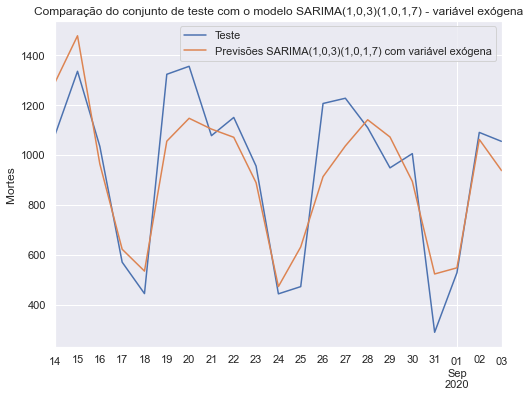

In [79]:
ylabel='Mortes '
xlabel=''
title_sarima_ex = 'Comparação do conjunto de teste com o modelo SARIMA(1,0,3)(1,0,1,7) - variável exógena'

ax = dados_teste[attr_b].plot(legend=True, title=title_sarima_ex, label='Teste')
previ_ex.plot(legend=True)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

<span style='color:black'>
    Mesmo com a variável exógena, eu obtive o mesmo resultado do SARIMA sem variável exógena, pelo menos na escolha do modelo.<br>
    O gráfico, embora pareça ter as mesmas nuances, o SARIMA com variável exógena conseguiu chegar um pouco mais próximos dos picos baixos e, além disso, o começo, mesmo que um pouco mais acima dos dados de teste, acompanhou o mesmo formato, o que já difere do SARIMA sem variável exógena.
</span>

#### Obtendo a previsão do modelo de Redes Dinâmicas

##### Padronizando os dados

In [80]:
train = np.array(dados_treino[attr_b]).reshape(-1,1)
test  = np.array(dados_treino[attr_b]).reshape(-1,1)

Minímo: 0.0
Máximo: 1.0


(array([46., 44., 38., 22., 11.,  2.,  1.,  1.,  0.,  1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

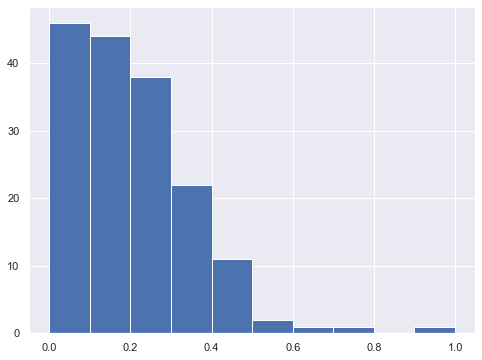

In [81]:
# Instanciando o objeto
scaler = MinMaxScaler()

# Adaptando o scaler a partir dos dados de treino
scaler.fit(train)

# Realizando a transformação/padronizando os dados
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Exibindo os resultados
print(f'Minímo: {scaled_test.min()}\nMáximo: {scaled_test.max()}')
plt.hist(scaled_train)

##### Definindo o gerador da série temporal

In [82]:
# Definir o gerador
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [83]:
print(f'Tamanho do conjunto de dados do treino: {len(scaled_train)}\nNovo tamanho definido pelo gerador: {len(generator)}')

Tamanho do conjunto de dados do treino: 166
Novo tamanho definido pelo gerador: 164


In [84]:
n_input = 7
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=2)

In [85]:
# Exibindo os possíveis valores
X,y = generator[0]

print(f'Dado o array: \n{X.flatten()}\n');
print(f'Previsão: \n {y}');

Dado o array: 
[0.         0.         0.00060889 0.00040593 0.00020296 0.
 0.00020296 0.         0.00060889 0.00040593 0.00020296 0.
 0.00020296 0.00040593]

Previsão: 
 [[0.00040593]
 [0.00060889]]


##### Criando e executando o modelo

In [86]:
# Definir o modelo
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [87]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [88]:
# Ajuste do modelo
model.fit_generator(generator, epochs=100);

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 2/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0110
Epoch 3/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 4/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 5/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 6/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 7/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 8/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 9/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 10/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 11/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 12/100
80/80 [======================

80/80 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 100/100
80/80 [==============================] - 0s 3ms/step - loss: 0.0070


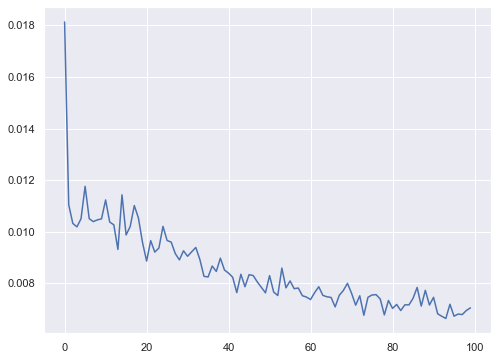

In [89]:
loss           = list(model.history.history.keys())[0]
loss_per_epoch = model.history.history[loss]

plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

In [90]:
first_eval_batch = scaled_train[-7:]

first_eval_batch

array([[0.37487315],
       [0.25390704],
       [0.21676477],
       [0.10391719],
       [0.10594682],
       [0.21818551],
       [0.3022123 ]])

In [91]:
# Considerarei as previsões para as próximas 21 observações e compararei com a base de teste
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(num_teste):
    
    # Obter a previsão de tempo 1 antecipadamente
    current_pred = model.predict(current_batch)[0]
    
    # Predição
    test_predictions.append(current_pred) 
    
    # Atualizazndo a rodada para incluir a previsão e descartar o primeiro valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [92]:
test_predictions

[array([0.2870575], dtype=float32),
 array([0.23563474], dtype=float32),
 array([0.1794818], dtype=float32),
 array([0.11534239], dtype=float32),
 array([0.09314024], dtype=float32),
 array([0.13162445], dtype=float32),
 array([0.18526718], dtype=float32),
 array([0.20721215], dtype=float32),
 array([0.196935], dtype=float32),
 array([0.16113672], dtype=float32),
 array([0.12171537], dtype=float32),
 array([0.09960434], dtype=float32),
 array([0.10592783], dtype=float32),
 array([0.13290234], dtype=float32),
 array([0.15686902], dtype=float32),
 array([0.16223873], dtype=float32),
 array([0.1470833], dtype=float32),
 array([0.12368548], dtype=float32),
 array([0.10591517], dtype=float32),
 array([0.10182616], dtype=float32),
 array([0.11182337], dtype=float32)]

In [93]:
scaled_test

array([[0.00000000e+00],
       [0.00000000e+00],
       [6.08889791e-04],
       [4.05926527e-04],
       [2.02963264e-04],
       [0.00000000e+00],
       [2.02963264e-04],
       [4.05926527e-04],
       [6.08889791e-04],
       [8.11853055e-04],
       [2.02963264e-04],
       [2.02963264e-04],
       [1.82666937e-03],
       [1.21777958e-03],
       [1.82666937e-03],
       [2.23259590e-03],
       [3.04444895e-03],
       [4.46519180e-03],
       [8.32149381e-03],
       [0.00000000e+00],
       [2.19200325e-02],
       [1.60340978e-02],
       [2.63852243e-02],
       [2.39496651e-02],
       [4.26222854e-02],
       [5.03348894e-02],
       [4.97259996e-02],
       [8.32149381e-02],
       [9.80312563e-02],
       [6.43393546e-02],
       [1.33955754e-01],
       [1.84290643e-01],
       [2.14735133e-01],
       [1.85508423e-01],
       [2.23868480e-01],
       [2.72579663e-01],
       [2.32392937e-01],
       [2.72173737e-01],
       [3.86645017e-01],
       [3.89892429e-01],


##### Retorno de padronização e exibição do gráfico

In [94]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[1415.33224908],
       [1161.97238451],
       [ 885.30685014],
       [ 569.29197286],
       [ 459.90198457],
       [ 649.51364209],
       [ 913.81139687],
       [1021.93426353],
       [ 971.29873532],
       [ 794.92060271],
       [ 600.69164913],
       [ 491.75057533],
       [ 522.90643036],
       [ 655.80982475],
       [ 773.89368144],
       [ 800.35023247],
       [ 725.67940615],
       [ 610.39835584],
       [ 522.84406175],
       [ 502.69749597],
       [ 551.95371981]])

In [95]:
rede_din = 'Rede Dinamica'

dados_teste[rede_din] = true_predictions

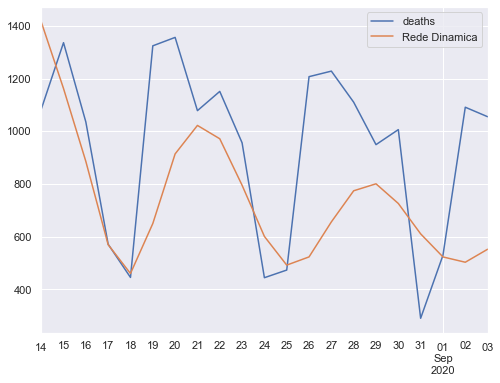

In [96]:
lst_attr_pred = ['deaths', rede_din]

dados_teste[lst_attr_pred].plot();

<span style='color:black'>
    Em comparação, graficamente, com a previsão das redes sarima, a rede dinâmica conseguiu um bom resultado e até mesmo chegando próximo do primeiro pico abaixo, porém o modelo SARIMA com variável exógena foi o que se aproximou mais dos restantes dos dados.
</span>

### Questão 4
Utilize o erro quadrático médio e erro quadrático absoluto para comparar as
previsões obtidas com as observações da base de teste. 

In [97]:
# Método para devolver o cálculo do Erro Quadrático Médio e Erro Absoluto Médio com o nome do modelo predito em um dataframe
def obtain_mse_mae(df_teste, attr, predict, name_model):
    
    name_mse = 'Mean Squared Error'
    name_mae = 'Mean Absolute Error'
    
    mse = mean_squared_error(df_teste[attr], predict)
    mae = mean_absolute_error(df_teste[attr], predict)
    
    print(f'Erro quadrático médio do modelo {name_model}: {mse}'
          f'\nErro absoluto médio do modelo {name_model}: {mae}')
    
    dc_mse_mae = {name_model : {name_mae : mae, name_mse : mse}}
    
    df_mse_mae = pd.DataFrame(data = dc_mse_mae.values(), index = dc_mse_mae.keys())
    
    return df_mse_mae

In [98]:
# Inicializando a variável do nome do modelo
name_pre  = covid_h_pred_a.name

# Chamando o método de MSE e MAE
df_holt_a = obtain_mse_mae(dados_teste, attr_b, covid_h_pred_a, name_pre)

print(f'\n{df_holt_a}')

Erro quadrático médio do modelo Previsão Holt Aditiva: 178068.29779866792
Erro absoluto médio do modelo Previsão Holt Aditiva: 309.30967231100925

                       Mean Absolute Error  Mean Squared Error
Previsão Holt Aditiva           309.309672       178068.297799


In [99]:
# Inicializando a variável do nome do modelo
name_pre  = covid_h_pred_m.name

# Chamando o método de MSE e MAE
df_holt_m = obtain_mse_mae(dados_teste, attr_b, covid_h_pred_m, name_pre)

print(f'\n{df_holt_m}')

Erro quadrático médio do modelo Previsão Holt Multiplicativa: 110218.34629702297
Erro absoluto médio do modelo Previsão Holt Multiplicativa: 251.36296010282166

                              Mean Absolute Error  Mean Squared Error
Previsão Holt Multiplicativa            251.36296       110218.346297


In [100]:
# Inicializando a variável do nome do modelo
name_pre = covid_hw_pred_a.name

# Chamando o método de MSE e MAE
df_hw_a  = obtain_mse_mae(dados_teste, attr_b, covid_hw_pred_a, name_pre)

print(f'\n{df_hw_a}')

Erro quadrático médio do modelo Previsão Holt-Winters Aditiva: 61885.13185222053
Erro absoluto médio do modelo Previsão Holt-Winters Aditiva: 211.61492070969896

                               Mean Absolute Error  Mean Squared Error
Previsão Holt-Winters Aditiva           211.614921        61885.131852


In [101]:
# Inicializando a variável do nome do modelo
name_pre = covid_hw_pred_am.name

# Chamando o método de MSE e MAE
df_hw_am = obtain_mse_mae(dados_teste, attr_b, covid_hw_pred_am, name_pre)

print(f'\n{df_hw_am}')

Erro quadrático médio do modelo Previsão Holt-Winters Aditiva e Multiplicativa: 55684.05972947289
Erro absoluto médio do modelo Previsão Holt-Winters Aditiva e Multiplicativa: 183.51114325451613

                                                Mean Absolute Error  \
Previsão Holt-Winters Aditiva e Multiplicativa           183.511143   

                                                Mean Squared Error  
Previsão Holt-Winters Aditiva e Multiplicativa        55684.059729  


In [102]:
# Inicializando a variável do nome do modelo
name_pre = covid_hw_pred_m.name

# Chamando o método de MSE e MAE
df_hw_m  = obtain_mse_mae(dados_teste, attr_b, covid_hw_pred_m, name_pre)

print(f'\n{df_hw_m}')

Erro quadrático médio do modelo Previsão Holt-Winters Multiplicativa: 26188.13413172301
Erro absoluto médio do modelo Previsão Holt-Winters Multiplicativa: 139.4780039270023

                                      Mean Absolute Error  Mean Squared Error
Previsão Holt-Winters Multiplicativa           139.478004        26188.134132


In [103]:
# Inicializando a variável do nome do modelo
name_pre  = previsoes.name

# Chamando o método de MSE e MAE
df_sarima = obtain_mse_mae(dados_teste, attr_b, previsoes, name_pre)

print(f'\n{df_sarima}')

Erro quadrático médio do modelo Previsões SARIMA(1,0,3)(1,0,1,7) : 28088.903999913968
Erro absoluto médio do modelo Previsões SARIMA(1,0,3)(1,0,1,7) : 135.00619803112374

                                   Mean Absolute Error  Mean Squared Error
Previsões SARIMA(1,0,3)(1,0,1,7)            135.006198           28088.904


In [104]:
# Inicializando a variável do nome do modelo
name_pre = previ_ex.name

# Chamando o método de MSE e MAE
df_sarima_ex = obtain_mse_mae(dados_teste, attr_b, previ_ex, name_pre)

print(f'\n{df_sarima_ex}')

Erro quadrático médio do modelo Previsões SARIMA(1,0,3)(1,0,1,7) com variável exógena: 21597.00243508545
Erro absoluto médio do modelo Previsões SARIMA(1,0,3)(1,0,1,7) com variável exógena: 121.4594774418028

                                                    Mean Absolute Error  \
Previsões SARIMA(1,0,3)(1,0,1,7) com variável e...           121.459477   

                                                    Mean Squared Error  
Previsões SARIMA(1,0,3)(1,0,1,7) com variável e...        21597.002435  


In [105]:
# Chamando o método de MSE e MAE
df_rede_dinamica = obtain_mse_mae(dados_teste, attr_b, true_predictions, rede_din)

print(f'\n{df_rede_dinamica}')

Erro quadrático médio do modelo Rede Dinamica: 124332.86484249897
Erro absoluto médio do modelo Rede Dinamica: 276.2328625356867

               Mean Absolute Error  Mean Squared Error
Rede Dinamica           276.232863       124332.864842


In [106]:
lst_dfs = [df_holt_a, df_holt_m, df_hw_a, df_hw_am, df_hw_m, df_sarima, df_sarima_ex, df_rede_dinamica]

df_pred_mse_mae = pd.concat(lst_dfs)
df_pred_mse_mae

Mean Absolute Error  \
Previsão Holt Aditiva                                        309.309672   
Previsão Holt Multiplicativa                                 251.362960   
Previsão Holt-Winters Aditiva                                211.614921   
Previsão Holt-Winters Aditiva e Multiplicativa               183.511143   
Previsão Holt-Winters Multiplicativa                         139.478004   
Previsões SARIMA(1,0,3)(1,0,1,7)                             135.006198   
Previsões SARIMA(1,0,3)(1,0,1,7) com variável e...           121.459477   
Rede Dinamica                                                276.232863   

                                                    Mean Squared Error  
Previsão Holt Aditiva                                    178068.297799  
Previsão Holt Multiplicativa                             110218.346297  
Previsão Holt-Winters Aditiva                             61885.131852  
Previsão Holt-Winters Aditiva e Multiplicativa            55684.059729  
Previsão Holt-Winters Multiplicativa                      26188.134132  
Previsões SARIMA(1,0,3)(1,0,1,7)                          28088.904000  
Previsões SARIMA(1,0,3)(1,0,1,7) com variável e...        21597.002435  
Rede Dinamica                                            124332.864842

<span style='color:black'>
    Meus valores mais baixos do erro absoluto médio e o erro quadrático médio foi <strong>SARIMA(1,0,3)x(1,0,1,7) com variável exógena</strong>.<br>
    Na quinta 5, eu precisaria prever 14 dias para variável confirmed e esse teste do exógeno fiz a pouco tempo de entregar a prova.<br>
    Utilizarei o segundo melhor modelo o SARIMA(1,0,3)x(1,0,1,7) sem variável exógena, dei prioridade para o erro absoluto médio, pois olhando o EQM o segundo modelo seria HW tendência e sazonalidade multiplicativa.
</span>    

### Questão 5 
Considere o método que produziu a melhor previsão para os dados de teste e faça a
previsão para mais 14 dias (além das observações da base de dados). Essa
previsão pode ser apresentada com um gráfico nos arquivos .ipynb e .pdf

In [107]:
titulo_sar = 'Previsão SARIMA(1,0,3)x(1,0,1,7) por mais 14 dias'

SARIMAX(covidUSA[attr_b], order=(1,0,3), seasonal_order=(1,0,1,7), enforce_invertibility=False)

resultado_sarima = modelo.fit()

inicio=len(covidUSA)
fim=len(covidUSA) + 14

fcast   = resultado_sarima.get_prediction(start=inicio, end=fim)
pred_ip =  fcast.conf_int(alpha = 0.42)

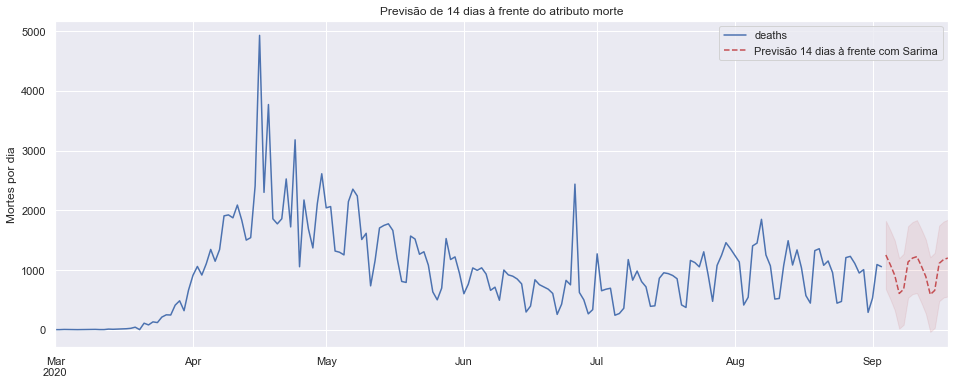

In [108]:
title='Previsão de 14 dias à frente do atributo morte'
ylabel='Mortes por dia'
xlabel=''

ax = covidUSA[attr_b].plot(legend=True,figsize=(16,6),title=title)

fcast.predicted_mean.plot(ax=ax, style='r--', label='Previsão 14 dias à frente com Sarima', legend=True)
ip = pred_ip.loc[covidUSA.index.max() :]
ax.fill_between(ip.index, ip.iloc[:,0], ip.iloc[:,1], color='r', alpha=0.1)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

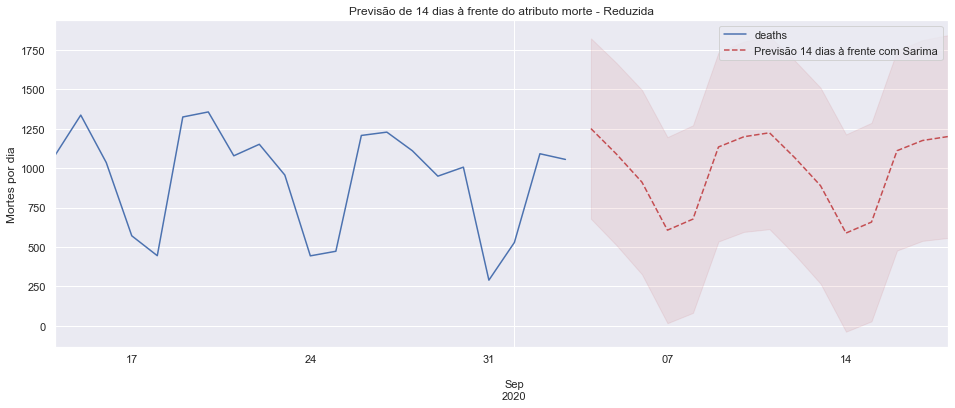

In [109]:
title='Previsão de 14 dias à frente do atributo morte - Reduzida'
ylabel='Mortes por dia'
xlabel=''

ax = dados_teste[attr_b].plot(legend=True,figsize=(16,6),title=title)

fcast.predicted_mean.plot(ax=ax, style='r--', label='Previsão 14 dias à frente com Sarima', legend=True)
ip = pred_ip.loc[dados_teste.index.max() :]
ax.fill_between(ip.index, ip.iloc[:,0], ip.iloc[:,1], color='r', alpha=0.1)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

<span style='color:black'>
    Diminuí o intervalo de confiança, aumentando o nível de sigificância em 42% ou $\alpha =$ 42%, pois com o $\alpha$ em 5% ou 10% o intervalo admitia valores negativos, o que para esse conjunto de dados não faz sentido.
    <br>Não vejo motivo de considerar o intervalo de confiança com valores negativos para o atributo deaths ou se eu estivesse predizendo o atributo confirmed também.
    <br>
    <br>Aproveitei para reduzir a quantidade de dias no conjunto de dados, olhando o conjunto de teste mais a previsão dos 14 dias para ter uma melhor visualização de tendência e sazonalidade. E, olhando esse segundo gráfico, a sensação é de que ocorre uma tendência estacionária nos números de mortes até a primeira quinzena de setembro.
</span>

##### Gerando o csv

In [110]:
dados_treino.head(5)

confirmed  deaths  Week    MMEP-7    DPEP-7
2020-03-01        3.0     1.0     9  1.000000       NaN
2020-03-02       20.0     1.0    10  1.000000  0.000000
2020-03-03       14.0     4.0    10  1.750000  1.697056
2020-03-04       22.0     3.0    10  2.062500  1.487299
2020-03-05       34.0     2.0    10  2.046875  1.231438

In [111]:
dados_teste.head(5)

confirmed  deaths  Week       MMEP-7      DPEP-7  Rede Dinamica
2020-08-14    51094.0  1083.0    33  1089.842690  384.387030    1617.645591
2020-08-15    64838.0  1336.0    33  1151.382018  352.235508    1414.299111
2020-08-16    48085.0  1035.0    33  1122.286513  309.863371    1078.284797
2020-08-17    42104.0   571.0    34   984.464885  372.146861     659.944507
2020-08-18    35056.0   445.0    34   849.598664  409.305639     520.965662

In [112]:
# Evitar problema e copiar para novos dataframe
covid_treino = dados_treino.copy()
covid_teste  = dados_teste.copy()

In [114]:
covid_teste['Holt - Tend Add']                      = covid_h_pred_a   
covid_teste['Holt - Tend Mul']                      = covid_h_pred_m   
covid_teste['Holt - Tend e Seaso ADD']              = covid_hw_pred_a  
covid_teste['Holt-Winters - Tend Add e Seaso Mul']  = covid_hw_pred_am 
covid_teste['Holt-Winters - Tend e Seaso Mul']      = covid_hw_pred_m
covid_teste['SARIMA(1,0,3)x(1,0,1,7)']              = previsoes
covid_teste['SARIMA(1,0,3)x(1,0,1,7) + var exóg']   = previ_ex

In [115]:
show_isna(covid_teste)

Existem valores nulos:
confirmed                              0
deaths                                 0
Week                                   0
MMEP-7                                 0
DPEP-7                                 0
Rede Dinamica                          0
Holt - Tend Add                        0
Holt - Tend Mul                        0
Holt - Tend e Seaso ADD                0
Holt-Winters - Tend Add e Seaso Mul    0
Holt-Winters - Tend e Seaso Mul        0
SARIMA(1,0,3)x(1,0,1,7)                0
SARIMA(1,0,3)x(1,0,1,7) + var exóg     0
dtype: int64



##### Realizar o fittedvalues no covid_treino

In [116]:
covid_treino['Holt - Tend Add']                     = covid_h_ajusted_a.fittedvalues;
covid_treino['Holt - Tend Mul']                     = covid_h_ajusted_m.fittedvalues;
covid_treino['Holt - Tend e Seaso ADD']             = covid_hw_ajusted_a.fittedvalues;  
covid_treino['Holt-Winters - Tend Add e Seaso Mul'] = covid_hw_ajusted_am.fittedvalues;
covid_treino['Holt-Winters - Tend e Seaso Mul']     = covid_hw_ajusted_m.fittedvalues;
covid_treino['SARIMA(1,0,3)x(1,0,1,7)']             = resultado.fittedvalues;
covid_treino['SARIMA(1,0,3)x(1,0,1,7) + var exóg']  = resultado_ex.fittedvalues;
covid_treino[rede_din]                              = np.nan

In [117]:
show_isna(covid_treino)

Existem valores nulos:
confirmed                                0
deaths                                   0
Week                                     0
MMEP-7                                   0
DPEP-7                                   1
Holt - Tend Add                          0
Holt - Tend Mul                          0
Holt - Tend e Seaso ADD                  0
Holt-Winters - Tend Add e Seaso Mul      0
Holt-Winters - Tend e Seaso Mul          0
SARIMA(1,0,3)x(1,0,1,7)                  0
SARIMA(1,0,3)x(1,0,1,7) + var exóg       0
Rede Dinamica                          166
dtype: int64



In [118]:
# Unindo os dataframes
covid_final = pd.concat([covid_treino, covid_teste])

In [119]:
show_isna(covid_final)

Existem valores nulos:
confirmed                                0
deaths                                   0
Week                                     0
MMEP-7                                   0
DPEP-7                                   1
Holt - Tend Add                          0
Holt - Tend Mul                          0
Holt - Tend e Seaso ADD                  0
Holt-Winters - Tend Add e Seaso Mul      0
Holt-Winters - Tend e Seaso Mul          0
SARIMA(1,0,3)x(1,0,1,7)                  0
SARIMA(1,0,3)x(1,0,1,7) + var exóg       0
Rede Dinamica                          166
dtype: int64



In [120]:
print(len(covid_final))

187


In [121]:
covid_final[166: 187]

confirmed  deaths  Week       MMEP-7      DPEP-7  Holt - Tend Add  \
2020-08-14    51094.0  1083.0    33  1089.842690  384.387030      1126.029816   
2020-08-15    64838.0  1336.0    33  1151.382018  352.235508      1132.818038   
2020-08-16    48085.0  1035.0    33  1122.286513  309.863371      1139.606260   
2020-08-17    42104.0   571.0    34   984.464885  372.146861      1146.394481   
2020-08-18    35056.0   445.0    34   849.598664  409.305639      1153.182703   
2020-08-19    44091.0  1324.0    34   968.198998  418.185924      1159.970925   
2020-08-20    47426.0  1356.0    34  1065.149248  405.039910      1166.759147   
2020-08-21    44005.0  1078.0    34  1068.361936  350.826341      1173.547369   
2020-08-22    49880.0  1151.0    34  1089.021452  306.273074      1180.335591   
2020-08-23    44378.0   956.0    34  1055.766089  272.439193      1187.123813   
2020-08-24    34506.0   444.0    35   902.824567  370.858757      1193.912035   
2020-08-25    38298.0   473.0    35   795.368425  378.901098      1200.700257   
2020-08-26    38119.0  1207.0    35   898.276319  380.446648      1207.488479   
2020-08-27    42848.0  1228.0    35   980.707239  363.781167      1214.276701   
2020-08-28    45909.0  1110.0    35  1013.030429  320.794815      1221.064923   
2020-08-29    49654.0   949.0    35   997.022822  279.425906      1227.853145   
2020-08-30    44143.0  1006.0    35   999.267117  242.026356      1234.641367   
2020-08-31    35581.0   290.0    36   821.950337  392.398915      1241.429589   
2020-09-01    33850.0   529.0    36   748.712753  366.409313      1248.217811   
2020-09-02    44639.0  1091.0    36   834.284565  355.416250      1255.006033   
2020-09-03    38754.0  1055.0    36   889.463424  324.649050      1261.794255   

            Holt - Tend Mul  Holt - Tend e Seaso ADD  \
2020-08-14      1086.450545              1327.389972   
2020-08-15      1079.967988              1164.748873   
2020-08-16      1073.524111               979.619957   
2020-08-17      1067.118683               697.419088   
2020-08-18      1060.751474               773.349739   
2020-08-19      1054.422256              1270.119225   
2020-08-20      1048.130803              1389.581946   
2020-08-21      1041.876890              1365.161546   
2020-08-22      1035.660292              1202.520447   
2020-08-23      1029.480787              1017.391531   
2020-08-24      1023.338153               735.190661   
2020-08-25      1017.232171               811.121312   
2020-08-26      1011.162621              1307.890798   
2020-08-27      1005.129287              1427.353520   
2020-08-28       999.131952              1402.933119   
2020-08-29       993.170401              1240.292020   
2020-08-30       987.244422              1055.163104   
2020-08-31       981.353801               772.962235   
2020-09-01       975.498328               848.892886   
2020-09-02       969.677793              1345.662372   
2020-09-03       963.891987              1465.125093   

            Holt-Winters - Tend Add e Seaso Mul  \
2020-08-14                          1513.935012   
2020-08-15                          1228.421831   
2020-08-16                           984.891332   
2020-08-17                           475.743212   
2020-08-18                           625.060960   
2020-08-19                          1329.456503   
2020-08-20                          1371.182404   
2020-08-21                          1546.311980   
2020-08-22                          1254.612806   
2020-08-23                          1005.826270   
2020-08-24                           485.825038   
2020-08-25                           638.267108   
2020-08-26                          1357.460440   
2020-08-27                          1399.978611   
2020-08-28                          1578.688949   
2020-08-29                          1280.803781   
2020-08-30                          1026.761208   
2020-08-31                           495.906864   
2020-09-01                 

<span style='color:black'>Aparentemente tudo ok, ufa!!</span>

In [122]:
# Gravando um csv com análise e inserção de novos campos no dataframe
covid_final.to_csv('covidUSA_Arion.csv', decimal = ',', sep = ';')